# **Apreciaciones Generales**


1.   Se realizará una regresión lineal multivariada
2.   Del conjunto de datos, se usará un 70% para entrenamiento y 30% para test



# **Librerías Comunes**

In [ ]:
# Common imports
import numpy as np
from numpy.linalg import inv
import os
# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

# **Configuraciones de los datos**

In [ ]:
DATA_PATH = "/content/drive/My Drive/Colab Notebooks"
DATA_PATH_FOR_GUEST = "/content"
def load_petrol_data(data_path=DATA_PATH):
    csv_path = os.path.join(data_path, "petrol_consumption.csv")
    return pd.read_csv(csv_path)

# **Cargando Datos**

In [ ]:
petrol_data = load_petrol_data()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
petrol_data.head()

In [ ]:
petrol_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 5 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Petrol_tax                    48 non-null     float64
 1   Average_income                48 non-null     int64  
 2   Paved_Highways                48 non-null     int64  
 3   Population_Driver_licence(%)  48 non-null     float64
 4   Petrol_Consumption            48 non-null     int64  
dtypes: float64(2), int64(3)
memory usage: 2.0 KB


In [ ]:
petrol_data.describe()

,Petrol_tax,Average_income,Paved_Highways,Population_Driver_licence(%),Petrol_Consumption
count,48.000000,48.000000,48.000000,48.000000,48.000000
mean,7.668333,4241.833333,5565.416667,0.570333,576.770833
std,0.950770,573.623768,3491.507166,0.055470,111.885816
min,5.000000,3063.000000,431.000000,0.451000,344.000000
25%,7.000000,3739.000000,3110.250000,0.529750,509.500000
50%,7.500000,4298.000000,4735.500000,0.564500,568.500000
75%,8.125000,4578.750000,7156.000000,0.595250,632.750000
max,10.000000,5342.000000,17782.000000,0.724000,968.000000


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
petrol_data.hist(bins=50, figsize=(20,15))
plt.show()

In [ ]:
#Tener siempre el mismo data set
np.random.seed(0)
#Split data
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [ ]:
#Separación de datos con un 30% para test
train_set, test_set = split_train_test(petrol_data, 0.3)
print(len(train_set), "train +", len(test_set), "test")

34 train + 14 test


In [ ]:
type(train_set)

pandas.core.frame.DataFrame

In [ ]:
#Separados los datos para finalmente empezar a entrenar
X_train = train_set.drop(columns=['Petrol_Consumption'])
y_train = train_set.iloc[:, 4]
X_test = test_set.drop(columns=['Petrol_Consumption'])
y_test = test_set.iloc[:, 4]

In [ ]:
# Normalización
X_media = np.concatenate((X_train, X_test), axis=0).mean(axis=0)
X_std = np.concatenate((X_train, X_test), axis=0).std(axis=0)
y_media = np.concatenate((y_train, y_test), axis=0).mean()
y_std = np.concatenate((y_train, y_test), axis=0).std()

In [ ]:
X_train = (X_train - X_media)/X_std
y_train = (y_train - y_media)/y_std
X_test = (X_test - X_media)/X_std
y_test = (y_test - y_media)/y_std

In [ ]:
#Agregar unos
X_train = pd.concat([pd.Series(1, index=X_train.index, name='00'), X_train], axis=1)
X_test = pd.concat([pd.Series(1, index=X_test.index, name='00'), X_test], axis=1)
print(X_train)

    00  Petrol_tax  ...  Paved_Highways  Population_Driver_licence(%)
47   1   -0.710378  ...        1.223922                      0.412952
2    1    1.415441  ...       -1.151803                      0.176112
46   1   -0.710378  ...       -0.429071                      0.959505
18   1   -0.710378  ...        0.101183                      2.799569
15   1   -0.710378  ...        1.381956                      0.285422
28   1    0.352532  ...        0.118550                     -0.133602
22   1    1.415441  ...       -0.902016                     -1.080961
16   1   -0.710378  ...        0.851702                      0.030364
41   1   -0.710378  ...       -0.457436                     -0.133602
20   1   -0.710378  ...        0.656619                      1.688243
42   1   -0.710378  ...       -0.558740                      0.595136
8    1    0.352532  ...        0.871673                     -0.753029
13   1   -0.710378  ...        0.293661                     -0.461534
25   1    1.415441  

#**Función de cálculo de coste**

In [ ]:
def hypothesis(theta, X):
    return theta*X

In [ ]:
#Mi función de coste re100 rob...cof cof, digo, prestada
def computeCost(X, y, theta):
    y1 = hypothesis(theta, X)
    y1=np.sum(y1, axis=1)
    return sum(np.sqrt((y1-y)**2))/(2*len(X))

In [ ]:
#Idea de las diapos
def Costo(x,y,theta):
  costo = np.sum(x.dot(theta.T - y)**2) / 2*len(x)
  return costo

#Recomendado
def errorCuadMedio(X,y,theta):
  y1 = hypothesis(theta,X)
  y1 = np.sum(y1, axis=1)
  return (np.square(y - y1)).mean()
#inner = np.power(((X @ theta.T) - y, 2)
#np.sum(inner) / 2 * len(X)

#**Función de Gradiente Descendiente**

In [ ]:
def gradientDescent(X, y, theta, alpha, i):
    J = []  
    k = 0
    #print(X)
    while k < i:       
        y1 = hypothesis(theta, X)
        #print(y1)
        y1 = np.sum(y1, axis=1)
        #print(y1-y)
        for c in range(0, len(theta)):
            theta[c] = theta[c] - alpha*(sum((y1-y)*X.iloc[:,c])/len(X))
            #print("new theta",theta[c] - alpha*sum((y1-y)*X.iloc[:,c])/len(X))
            #print("theta",theta[c])
        #print("theta",theta)
        j = computeCost(X, y, theta)
        #j = Costo(X,y,theta)
        J.append(j)
        k += 1
    return J, j, theta

#**Función de Ecuación Normal**

In [ ]:
def get_best_param(X, y):  
    X_transpose = X.T  
    best_params = inv(X_transpose.dot(X)).dot(X_transpose).dot(y)  
    # normal equation  
    # theta_best = (X.T * X)^(-1) * X.T * y  
      
    return best_params # returns a list

#**Experimento 1**

In [ ]:
theta = np.array([0]*len(X_train.columns),dtype=float)
#type(theta)
#print(X_train)
m = len(petrol_data)
J, j, theta = gradientDescent(X_train, y_train, theta, 0.05, 10000)
print(theta)

[ 0.02505777 -0.36836443 -0.36004218 -0.19523439  0.65697005]


In [ ]:
theta_for_normalEquation = get_best_param(X_train,y_train)
print(theta_for_normalEquation)

[-0.09125059 -0.37345738 -0.44395584 -0.19926878  0.65161751]


In [ ]:
y_hat = hypothesis(theta, X_test)
y_hat = np.sum(y_hat, axis=1)
y_hat_ne = hypothesis(theta_for_normalEquation, X_test)
y_hat_ne = np.sum(y_hat_ne,axis=1)
print(str(len(y_hat)) +" "+ str(len(y_test)))

14 14


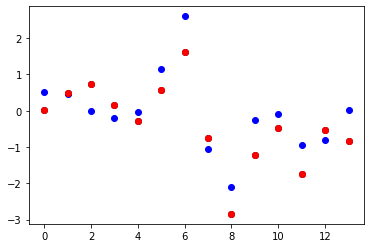

In [ ]:
#Plot the original y and the predicted output ‘y_hat’
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(x=list(range(0, 14)), y= y_test, color='blue')     #Original o lo que debería salir    
plt.scatter(x=list(range(0, 14)), y= y_hat, color='black')     #Nuestra predicción
plt.scatter(x=list(range(0, 14)), y= y_hat_ne, color='red')    #Predicción usando ecuación normal
plt.show()

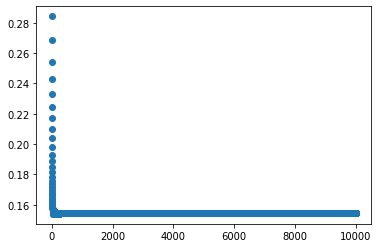

In [ ]:
#Plot the cost of each iteration to see the behavior
plt.figure()
plt.scatter(x=list(range(0, 10000)), y=J)
plt.show()

In [ ]:
print(J)

[0.24940821412288602, 0.24940821412288602, 0.24940821412288602, 0.24940821412288602, 0.24940821412288602, 0.24940821412288602, 0.24940821412288602, 0.24940821412288602, 0.24940821412288602, 0.24940821412288602, 0.24940821412288602, 0.24940821412288602, 0.24940821412288602, 0.24940821412288602, 0.24940821412288602, 0.24940821412288602, 0.24940821412288602, 0.24940821412288602, 0.24940821412288602, 0.24940821412288602, 0.24940821412288602, 0.24940821412288602, 0.24940821412288602, 0.24940821412288602, 0.24940821412288602, 0.24940821412288602, 0.24940821412288602, 0.24940821412288602, 0.24940821412288602, 0.24940821412288602, 0.24940821412288602, 0.24940821412288602, 0.24940821412288602, 0.24940821412288602, 0.24940821412288602, 0.24940821412288602, 0.24940821412288602, 0.24940821412288602, 0.24940821412288602, 0.24940821412288602, 0.24940821412288602, 0.24940821412288602, 0.24940821412288602, 0.24940821412288602, 0.24940821412288602, 0.24940821412288602, 0.24940821412288602, 0.2494082141

#**Experimento 2**

In [ ]:
def load_wine_data(data_path=DATA_PATH):
    csv_path = os.path.join(data_path, "winequality-red.csv")
    return pd.read_csv(csv_path, nrows=100)

In [ ]:
wine_data = load_wine_data()

In [ ]:
wine_data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.00000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,7.580000,0.560500,0.217700,2.458000,0.100560,15.950000,56.39000,0.996766,3.333400,0.708100,9.783000,5.250000
std,1.065909,0.164431,0.178336,1.361886,0.068928,10.575725,37.36684,0.001098,0.161922,0.303344,0.686236,0.657129
min,4.600000,0.220000,0.000000,1.200000,0.045000,3.000000,10.00000,0.993200,2.930000,0.390000,9.000000,4.000000
25%,7.000000,0.430000,0.067500,1.800000,0.074000,9.000000,26.25000,0.996200,3.245000,0.550000,9.400000,5.000000
50%,7.650000,0.570000,0.195000,2.000000,0.082000,13.500000,46.00000,0.996800,3.340000,0.590000,9.500000,5.000000
75%,8.100000,0.662500,0.302500,2.400000,0.097250,19.250000,82.25000,0.997425,3.412500,0.755000,10.100000,6.000000
max,11.200000,1.130000,0.700000,10.700000,0.464000,52.000000,148.00000,0.999300,3.900000,1.980000,13.100000,7.000000


In [ ]:
#Separación de datos con un 30% para test
train_set, test_set = split_train_test(wine_data, 0.3)
print(len(train_set), "train +", len(test_set), "test")

70 train + 30 test


In [ ]:
#Separados los datos para finalmente empezar a entrenar
X_train = train_set[['density','pH','alcohol']]
y_train = train_set.iloc[:, 11]
X_test = test_set[['density','pH','alcohol']]
y_test = test_set.iloc[:, 11]

In [ ]:
# Normalización
X_media = np.concatenate((X_train, X_test), axis=0).mean(axis=0)
X_std = np.concatenate((X_train, X_test), axis=0).std(axis=0)
y_media = np.concatenate((y_train, y_test), axis=0).mean()
y_std = np.concatenate((y_train, y_test), axis=0).std()

In [ ]:
X_train = (X_train - X_media)/X_std
y_train = (y_train - y_media)/y_std
X_test = (X_test - X_media)/X_std
y_test = (y_test - y_media)/y_std

In [ ]:
#Agregar unos
X_train = pd.concat([pd.Series(1, index=X_train.index, name='00'), X_train], axis=1)
X_test = pd.concat([pd.Series(1, index=X_test.index, name='00'), X_test], axis=1)
print(X_train)

    00   density        pH   alcohol
33   1  2.318589  0.723729 -0.560929
97   1 -0.426386 -0.517659 -0.853842
68   1  0.122609 -0.331451  1.343006
96   1 -0.243388  0.723729  1.343006
67   1 -0.517885  0.661660  1.343006
..  ..       ...       ...       ...
2    1  0.214108 -0.455589  0.024898
10   1 -0.792383 -0.331451 -0.853842
39   1  0.946101 -0.021104  1.050093
76   1  1.678095  1.282353  1.050093
74   1  1.495096 -0.331451 -0.268015

[70 rows x 4 columns]


In [ ]:
#Entrenamiento
theta = np.array([0]*len(X_train.columns),dtype=float)
#type(theta)
#print(X_train)
m = len(wine_data)
J, j, theta = gradientDescent(X_train, y_train, theta, 0.05, 1000)
print(theta)

[-0.05311862 -0.03762629 -0.21690498  0.12503636]


In [ ]:
theta_for_normalEquation = get_best_param(X_train,y_train)
print(theta_for_normalEquation)

[-0.05311862 -0.03762629 -0.21690498  0.12503636]


In [ ]:
y_hat = hypothesis(theta, X_test)
y_hat = np.sum(y_hat, axis=1)
y_hat_ne = hypothesis(theta_for_normalEquation, X_test)
y_hat_ne = np.sum(y_hat_ne,axis=1)
print(str(len(y_hat)) +" "+ str(len(y_test)))

30 30


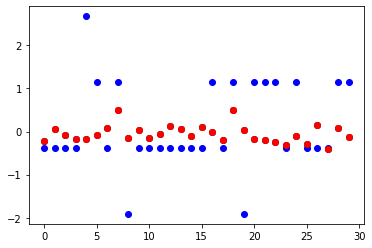

In [ ]:
#Plot the original y and the predicted output ‘y_hat’
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(x=list(range(0, 30)), y= y_test, color='blue')     #Original o lo que debería salir    
plt.scatter(x=list(range(0, 30)), y= y_hat, color='black')     #Nuestra predicción
plt.scatter(x=list(range(0, 30)), y= y_hat_ne, color='red')    #Predicción usando ecuación normal
plt.show()

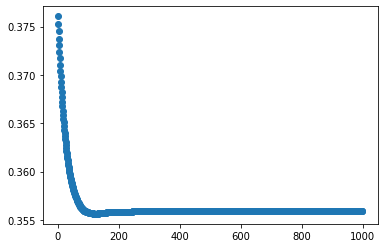

In [ ]:
#Plot the cost of each iteration to see the behavior
plt.figure()
plt.scatter(x=list(range(0, 1000)), y=J)
plt.show()